In [1]:
import torch
import numpy as np
from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
print(device)


cuda:0


#### generate data according to experiment 3

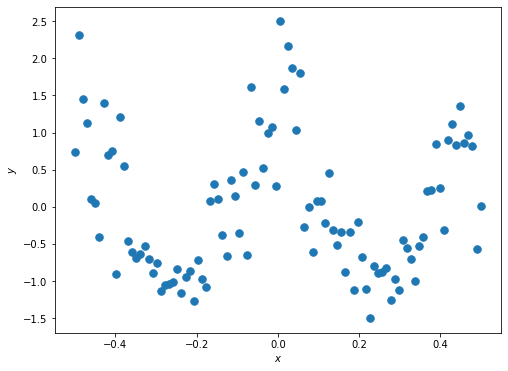

In [3]:
from scipy.stats import norm
def gen3(x,q):
  z=torch.from_numpy(norm.ppf(q)).float()
  muintermediate=torch.cos(x*2*2*3.14159)
  sdintermediate=(.2+.3*(muintermediate+1))
  y=muintermediate+sdintermediate*z
  return muintermediate,sdintermediate,y
experiment=3
if experiment==0:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  y=5*x+.5*torch.randn(n,1)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()
elif experiment==1:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  y=-1+2*(x>0)+.5*torch.randn(n,1)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()
elif experiment==2:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  y=torch.cos(x*2*2*3.14159)+.5*torch.randn(n,1)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()
elif experiment==3:
  n=100
  torch.manual_seed(42)
  x=torch.linspace(-.5,.5,n).reshape(-1,1)
  np.random.seed(42)
  q=np.random.rand(n,1)
  mu3,sd3,y=gen3(x,q)
  figure=plt.figure(figsize=[8,6])
  plt.plot(x,y,'.',ms=15) 
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.show()

In [ ]:
### save result for other comparisons
xymusd=np.c_[x.detach().numpy(),y.detach().numpy(),mu3.detach().numpy(),sd3.detach().numpy()]
np.save(r'/content/drive/My Drive/overfit_discover/xymusd',xymusd)

In [ ]:
class my_dataset(Dataset):
    def __init__(self,data,label):
        self.data=x
        self.label=y          
    def __getitem__(self, index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data)

## point estimate model

In [ ]:
class mlp_regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.k1=1000
        self.k2=1000
        self.fc1 = nn.Linear(1, self.k1)
        self.bn1 = nn.BatchNorm1d(self.k1)
        self.fc2 = nn.Linear(self.k1, self.k2)
        self.bn2 = nn.BatchNorm1d(self.k2)
        self.fc3 = nn.Linear(self.k2, 1)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = self.bn1(h1)
        h2 = F.relu(self.fc2(h1))
        h2 = self.bn2(h2)
        h3 = self.fc3(h2)
        return h3

### mlp linear regression overfit

In [ ]:
dataloader = DataLoader(dataset=my_dataset(x,y),
                            batch_size=n,
                            shuffle=True)

epochs = 40000
model = mlp_regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-5)
mlp_loss = []

for epoch in range(epochs):
    for instances, labels in dataloader:
        instances, labels = instances.to(device), labels.to(device)
        optimizer.zero_grad()
        
        output = model(instances)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
    mlp_loss.append(loss.item())

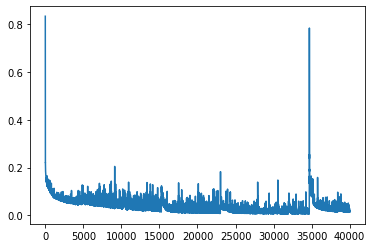

In [ ]:
plt.plot(mlp_loss)

In [ ]:
y_mlp=model(x.to(device)).to(cpu)

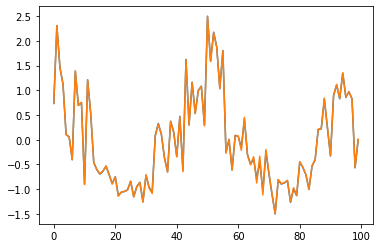

In [ ]:
plt.plot(y_mlp.detach())
plt.plot(y)

## quantile regression overfit: a percentile at a time

In [ ]:
def tilted_loss(q=.5):
    def qloss(output,labels):
        higher=output>labels
        higher=higher.float()
        intermediate=(q*higher+(1-q)*(1-higher))*torch.abs(output-labels)
        loss=torch.mean(intermediate)
        return loss
    return qloss

In [ ]:
dataloader = DataLoader(dataset=my_dataset(x,y),
                            batch_size=n,
                            shuffle=True)

epochs = 50000
model_tl_25 = mlp_regressor().to(device)
model_tl_50 = mlp_regressor().to(device)
model_tl_75 = mlp_regressor().to(device)

criterion25 = tilted_loss(q=.25)
criterion50 = tilted_loss(q=.5)
criterion75 = tilted_loss(q=.75)


optimizer25 = optim.Adam(model_tl_25.parameters(), lr=1e-5)
optimizer50 = optim.Adam(model_tl_50.parameters(), lr=1e-5)
optimizer75 = optim.Adam(model_tl_75.parameters(), lr=1e-5)

ql25_loss = []
ql50_loss = []
ql75_loss = []

for epoch in range(epochs):
    for instances, labels in dataloader:
        instances, labels = instances.to(device), labels.to(device)

        optimizer25.zero_grad() 
        output25 = model_tl_25(instances)
        loss25 = criterion25(output25, labels)
        loss25.backward()
        optimizer25.step()


        optimizer50.zero_grad() 
        output50 = model_tl_50(instances)
        loss50 = criterion50(output50, labels)
        loss50.backward()
        optimizer50.step()


        optimizer75.zero_grad() 
        output75 = model_tl_75(instances)
        loss75 = criterion75(output75, labels)
        loss75.backward()
        optimizer75.step()

    ql25_loss.append(loss25.item())
    ql50_loss.append(loss50.item())
    ql75_loss.append(loss75.item())




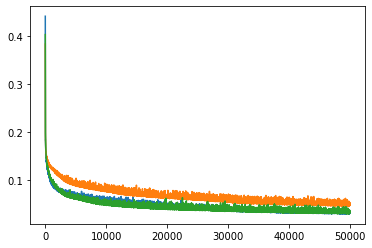

In [ ]:
plt.plot(ql25_loss)
plt.plot(ql50_loss)
plt.plot(ql75_loss)

In [ ]:
y_25=model_tl_25(x.to(device)).to(cpu)
y_50=model_tl_50(x.to(device)).to(cpu)
y_75=model_tl_75(x.to(device)).to(cpu)

In [ ]:
### save result for point estimate
mse_qr25_50_75=np.c_[y_mlp.detach().numpy(),y_25.detach().numpy(),y_50.detach().numpy(),y_75.detach().numpy()]
np.save(r'/content/drive/My Drive/overfit_discover/mse_qr25_50_75',mse_qr25_50_75)

In [5]:
from scipy import stats

In [6]:
dt=np.load(r'/content/drive/My Drive/overfit_discover/xymusd.npy')
x=dt[:,0]
y=dt[:,1]
med=dt[:,2].ravel()
std=dt[:,3].ravel()
up=med+stats.norm.ppf(0.75)*std
low=med+stats.norm.ppf(0.25)*std

In [7]:
mse_qr25_50_75=np.load(r'/content/drive/My Drive/overfit_discover/mse_qr25_50_75.npy')

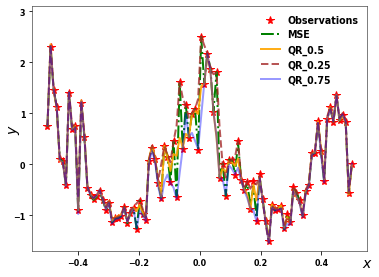

In [8]:

fig = plt.gcf()
fig.set_size_inches(6,4.5)


plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelpad"] = 0


plt.rcParams['axes.linewidth'] = 0.5



plt.rcParams['axes.labelsize'] = 10

plt.rcParams['axes.titlesize'] = 10

plt.rcParams['xtick.labelsize'] = 8

plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 9.5
plt.plot(x,y,'*',ms=8,color='red')
plt.plot(x,mse_qr25_50_75[:,0],'-.',lw=2,color='green')
plt.plot(x,mse_qr25_50_75[:,2],'-',lw=2,alpha=0.9,color='orange')
plt.plot(x,mse_qr25_50_75[:,1],'--',lw=2,alpha=0.8,color='brown')
plt.plot(x,mse_qr25_50_75[:,3],'-',lw=2,alpha=0.4,color='blue')
plt.legend(['Observations','MSE','QR_0.5','QR_0.25','QR_0.75'],frameon=False)
plt.xlabel('$x$',fontsize=14)
plt.gca().xaxis.set_label_coords(1.0, -0.02)
plt.ylabel('$y$',fontsize=14)
plt.gca().yaxis.set_label_coords(-0.03, 0.5)

plt.ylim([-1.7,3.1])
plt.xlim([-0.55,0.55])
fig.savefig(r'/content/drive/My Drive/overfit_discover/pt_mseqr.pdf',transparent=True,bbox_inches = 'tight',
    pad_inches = 0.2)